# Plot TBB beamformed data from DM0

In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import dedispersion as dd
from scipy import optimize
#%pylab inline

## Extracting data

In [6]:
def data(file, DM=26.8, nch=16, t_int=6):
    f_bf=h5py.File(file,'r')
    
    st=list(f_bf.keys())[0]
    # We need to make sure the subbands are read in order
    subbands=sorted(list(f_bf[st]['BFDATA'].keys()))
    #subbands=np.delete(subbands, np.where('WEIGHTS' in subbands))
    nsb=len(subbands)
    datalen=f_bf[st]['BFDATA'][subbands[0]].shape[0]
    datalen=datalen-datalen%(2*nch*t_int)


#     print(f_bf[st][subbands[0]].attrs[u'CENTRAL_FREQUENCY'], subbands[0])
#     print(f_bf[st][subbands[0]].attrs['BANDWIDTH'])
#     print(f_bf[st][subbands[0]].attrs['BANDWIDTH_UNIT']=='Hz')
#     print(f_bf[st][subbands[0]].attrs['TIME_RESOLUTION'])
#     print(f_bf[st][subbands[0]].attrs['TIME_RESOLUTION_UNIT']=='s')
#     list(f_bf[st][subbands[0]].attrs)
    
    complexdynspec=np.zeros(dtype=f_bf[st]['BFDATA'][subbands[0]].dtype,shape=(nsb,datalen)) #f_bf[st][subbands[0]].dtype
    subband_frequencies=np.zeros(dtype=float,shape=(nsb))
    weights=np.zeros(dtype=f_bf[st][u'WEIGHTS'][subbands[0]].dtype,shape=(nsb,datalen))
    
    for num,sb in enumerate(subbands):
        complexdynspec[num]=f_bf[st]['BFDATA'][sb][0:datalen]
        subband_frequencies[num]=f_bf[st]['BFDATA'][sb].attrs[u'CENTRAL_FREQUENCY']
        weights[num]=f_bf[st][u'WEIGHTS'][sb][0:datalen]
    
    # Same resolution as BF data : nch=16
    data01=complexdynspec[:,:].T
    s=data01.shape; fftdata01=np.fft.fft(data01.reshape(s[0]//nch,nch,s[1]).swapaxes(1,2),axis=2).reshape(s[0]//nch,nch*s[1])

    # Dynamic spectrum
    assert(f_bf[st]['BFDATA'][subbands[0]].attrs['BANDWIDTH_UNIT']==b'Hz'), "Bandwidth not in Hz"
    subband_bandwidth=f_bf[st]['BFDATA'][subbands[0]].attrs['BANDWIDTH'] #Hz
    assert(f_bf[st]['BFDATA'][subbands[0]].attrs['TIME_RESOLUTION_UNIT']==b's'), "Time resolution not in s"
    subband_timeresolution=f_bf[st]['BFDATA'][subbands[0]].attrs['TIME_RESOLUTION'] #seconds
    
    channel_timeresolution=subband_timeresolution*nch
    channel_bandwidth=subband_bandwidth/nch
    channel_frequencies=np.zeros(dtype=float,shape=(nsb,nch))
    channel_delays=np.zeros(dtype=int,shape=(nsb,nch))

    for num,sbfreq in enumerate(subband_frequencies):
        channel_frequencies[num]=(np.arange(nch)-nch/2)*channel_bandwidth+sbfreq
        channel_delays[num]=dd.freq_to_delay(DM,channel_frequencies[num],channel_timeresolution)
    channel_frequencies=channel_frequencies.reshape((nsb*nch))
    channel_delays=channel_delays.reshape((nsb*nch))

    dynspec1=np.abs(fftdata01)
    if False:
        for ch,delay in enumerate(channel_delays):
            if int(delay)>=1:
                dynspec1[0:-int(delay),ch]=dynspec1[int(delay):,ch]
                dynspec1[-int(delay):,ch]=0 #dynspec[0:int(delay),ch]
    #print("Dynspec shape : ", dynspec.shape)
    
    # Spectrum
    specstd=np.std(dynspec1,axis=0)
    spect_raw=np.sum(dynspec1,axis=0)
    noisyness=(spect_raw/np.median(spect_raw))/(specstd/np.median(specstd))
    flagfreq=(noisyness<0.95)|(noisyness>1.05)

    # Start time
    starttime=[f_bf[st]['BFDATA'][sb].attrs['TIME']%100+f_bf[st]['BFDATA'][sb].attrs['SLICE_NUMBER']*subband_timeresolution for sb in sorted(subbands)]
    
    # Downsampling data
    f_int= 16 #nch//2 # Best visualized when nch/f_int=2
    dynspec2=np.sum(dynspec1.reshape(dynspec1.shape[0]//t_int,t_int,dynspec1.shape[1])/t_int,axis=1)
    dynspec3=np.sum(dynspec2.reshape(dynspec2.shape[0],dynspec2.shape[1]//f_int,f_int)/f_int,axis=2)
    spectrum=np.average(dynspec3,axis=0)
    
    # Filtered dynamic spectrum
    dynspec = (dynspec3/spectrum).T
    
    return dynspec, dynspec1, spectrum, spect_raw, subband_frequencies, starttime, channel_timeresolution, channel_frequencies, channel_delays


## Data extraction

Test 1

In [228]:
#outfilename='L597863_RS310_D20190809T090024.540Z_tbbbf_pol0_cal-1_weight-1.h5'
#outfilename='L43784_D20120125T211154.887Z_CS004_sbtbbbf_pol0_cal1_weight1.h5'
#outfilename='L597863_RS407_D20200128T162407.000Z_R001_tbbbf_pol0_cal1_weight1.h5'
outfilename1='/home/ines/Documents/projects/TBB/data/L597863_RS305_D20200128T153519.000Z_tbbbf_pol1_cal1_weight1.h5'
outfilename0='/home/ines/Documents/projects/TBB/data/L597863_RS305_D20200128T153519.000Z_tbbbf_pol0_3.h5'

In [39]:
# print(f_bf[st][subbands[0]].attrs[u'CENTRAL_FREQUENCY'])
# print(f_bf[st][subbands[0]].attrs['BANDWIDTH'])
# print(f_bf[st][subbands[0]].attrs['BANDWIDTH_UNIT']=='Hz')
# print(f_bf[st][subbands[0]].attrs['TIME_RESOLUTION'])
# print(f_bf[st][subbands[0]].attrs['TIME_RESOLUTION_UNIT']=='s')
# list(f_bf[st][subbands[0]].attrs)

In [149]:
DM    = 26.7641
nch   = 16
t_int = 24
dynspec_0, dynspec1_0, spectrum_0, spect_raw_0, fsb_0, t0_0, tch_0, fch_0, dch_0 = data(outfilename0, DM=DM, nch=nch, t_int=t_int)
dynspec_1, dynspec1_1, spectrum_1, spect_raw_1, fsb_1, t0_1, tch_1, fch_1, dch_1 = data(outfilename1, DM=DM, nch=nch, t_int=t_int)

dynspec   = dynspec_0**2 + dynspec_1**2

dynspec1  = dynspec1_0**2 + dynspec1_1**2
spectrum  = spectrum_0**2 + spectrum_1**2
spect_raw = spect_raw_0**2 + spect_raw_1**2
nsb = len(fsb_0)
fsb = fsb_0
t0  = t0_0
tch = tch_0
fch = fch_0
dch = dch_0

ValueError: operands could not be broadcast together with shapes (51,1706) (151,510) 

Test 2

In [8]:
outfilename0='/home/ines/Documents/projects/TBB/data/L597863_RS407_D20200205T192020.107Z_tbbbf_pol0_cal1_weight1.h5'
outfilename1='/home/ines/Documents/projects/TBB/data/L597863_RS407_D20200205T192020.107Z_tbbbf_pol1_cal1_weight1.h5'

DM=26.7641
DM    = 26.7641
nch   = 32
t_int = 32
#dynspec, dynspec1, spectrum, spect_raw, fsb, t0, tch, fch, dch = data(outfilename, DM=DM, nch=nch, t_int=t_int)
dynspec_0, dynspec1_0, spectrum_0, spect_raw_0, fsb_0, t0_0, tch_0, fch_0, dch_0 = data(outfilename0, DM=DM, nch=nch, t_int=t_int)
dynspec_1, dynspec1_1, spectrum_1, spect_raw_1, fsb_1, t0_1, tch_1, fch_1, dch_1 = data(outfilename1, DM=DM, nch=nch, t_int=t_int)

dynspec   = dynspec_0**2 + dynspec_1[:192]**2

dynspec1  = dynspec1_0**2 + dynspec1_1[:,:3072]**2
spectrum  = spectrum_0**2 + spectrum_1[:192]**2
spect_raw = spect_raw_0**2 + spect_raw_1[:3072]**2
nsb = len(fsb_0)
fsb = fsb_0
t0  = t0_0
tch = tch_0
fch = fch_0
dch = dch_0

Test 3

In [7]:
#outfilename0='/home/ines/Documents/projects/TBB/data/L597863_CS007_D20200211T161560.000Z_R005_tbbbf_pol1.h5'
outfilename0='/home/ines/Documents/projects/TBB/data/L597863_RS407_D20200128T162407.000Z_R001_tbbbf_pol0.h5'
DM    = 26.7641
nch   = 32
t_int = 16
dynspec, dynspec1, spectrum, spect_raw, fsb, t0, tch, fch, dch = data(outfilename0, DM=DM, nch=nch, t_int=t_int)

## Plotting

<IPython.core.display.Javascript object>


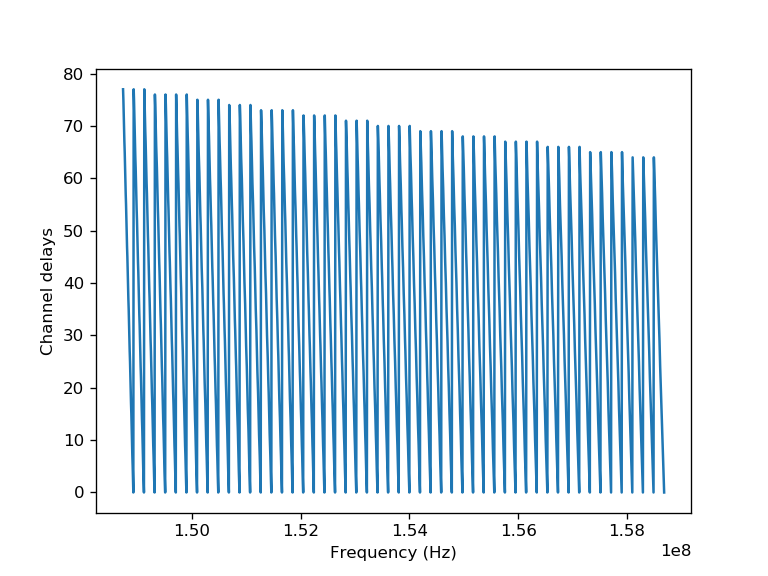

Text(0, 0.5, 'Channel delays')

In [8]:
%matplotlib notebook
plt.plot(fch, dch)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Channel delays")

<IPython.core.display.Javascript object>


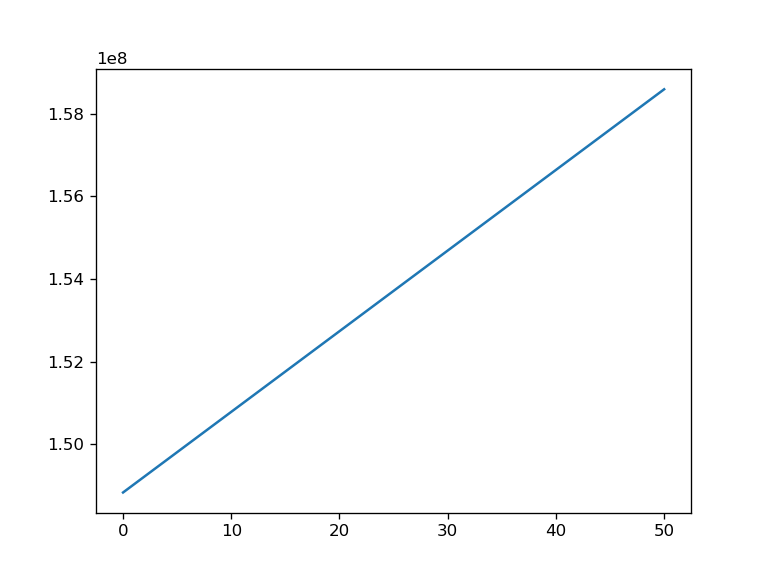

ValueError: x and y must have same first dimension, but have shapes (9664,) and (1632,)

In [233]:
%matplotlib notebook
plt.plot(fsb)
plt.plot(np.arange(nch*nsb)//nch,fch)

In [9]:
np.median(dynspec1)

20.95487354435678

<IPython.core.display.Javascript object>


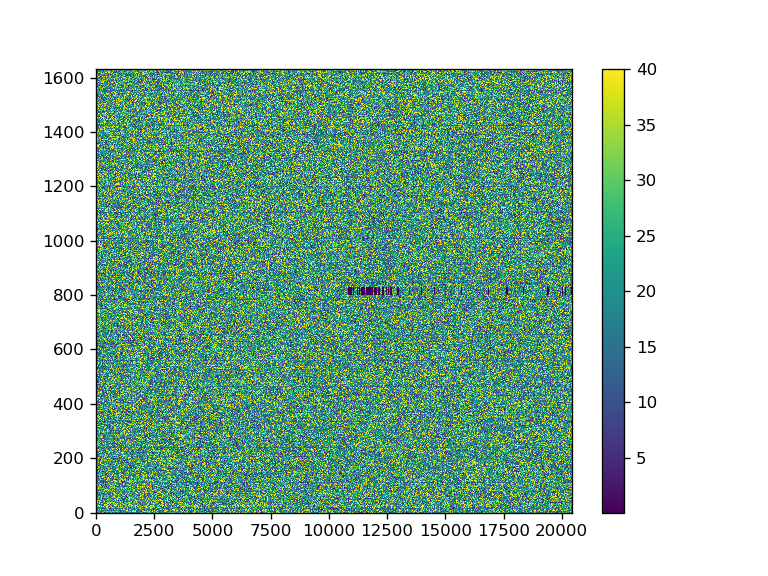

In [10]:
%matplotlib notebook
plt.imshow(dynspec1.T,aspect='auto',origin='lower',interpolation='nearest',vmin=0.04,vmax=40)
plt.colorbar()

<IPython.core.display.Javascript object>


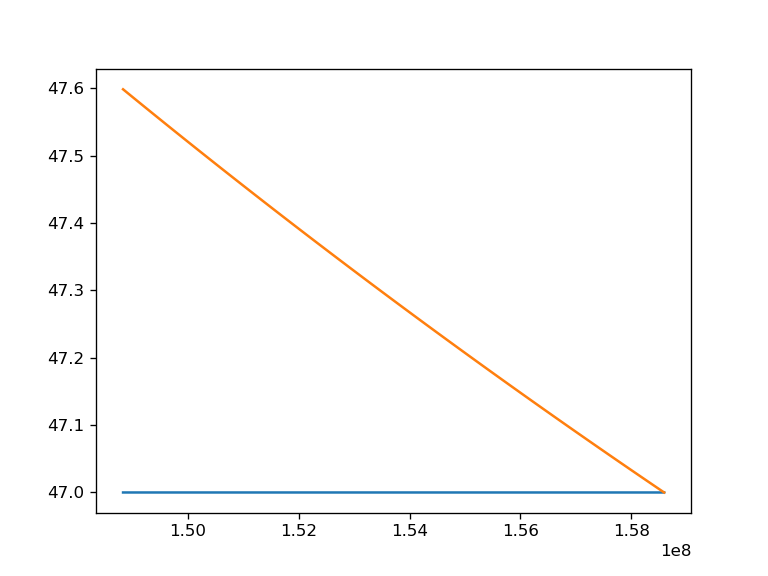

0.0 % offset


In [235]:
%matplotlib notebook
plt.plot(fsb,t0)
plt.plot(fsb,dd.freq_to_delay(DM,fsb,1)+t0[-1])
print(np.sum((dd.freq_to_delay(DM,fsb,1)+t0[-1]-t0)<-0.05)*100/len(fsb),'% offset')

In [11]:
print(np.max(dynspec), np.min(dynspec), np.median(dynspec), np.std(dynspec))
print(max(fch), min(fch), len(fch))

28.054978749883283 0.0 0.9957762389015496 0.21278997708338854
158685302.734375 148730468.75 1632


## Plotting dynamic spectrum

<IPython.core.display.Javascript object>


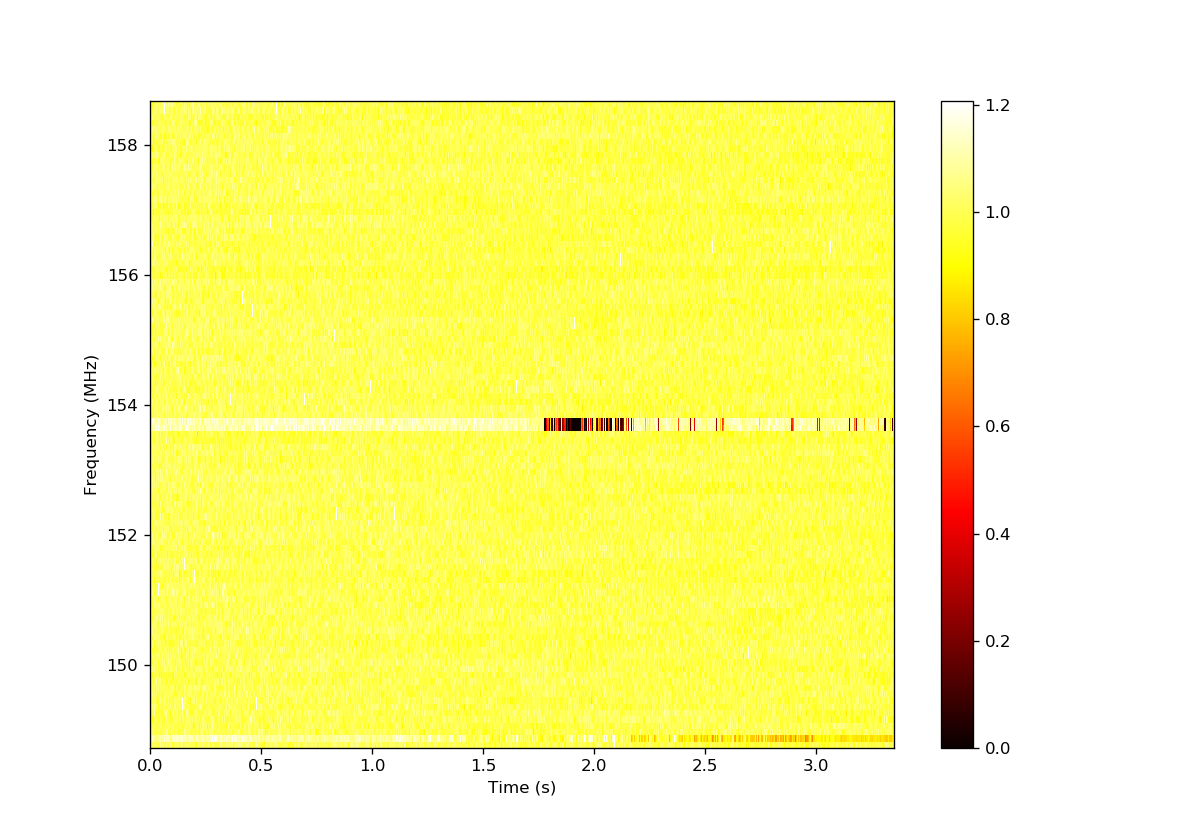

Text(0, 0.5, 'Frequency (MHz)')

In [12]:
%matplotlib notebook
cmin = min([np.median(dynspec)-np.std(dynspec), 0])
cmax = np.median(dynspec)+np.std(dynspec)

ch_freq = np.linspace(min(fch)*1e-6,max(fch)*1e-6,dynspec.shape[0]) # MHz
for line in np.where(spectrum>2*np.median(spectrum))[0] :
    dynspec[line] = np.median(dynspec) * np.ones(dynspec.shape[1])
for line in np.where(spectrum<np.median(spectrum)/2)[0] :
    dynspec[line] = np.median(dynspec) * np.ones(dynspec.shape[1])

plt.figure(figsize=(10,7))
plt.imshow(dynspec,aspect='auto',vmin=cmin, vmax=cmax,origin='lower',interpolation='nearest',cmap='hot',extent=[0,dynspec.shape[1]*tch*t_int,min(ch_freq),max(ch_freq)])
#plt.imshow(dynspec,aspect='auto',vmin=0.5, vmax=2,origin='lower',interpolation='nearest',cmap='hot',extent=[0,dynspec.shape[1]*tch*t_int,min(ch_freq),max(ch_freq)])
plt.colorbar()

#plt.xlim(1.5,3)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (MHz)")
# ch_freq = np.linspace(min(fch),max(fch),dynspec.shape[0])
# for line in np.where(spectrum>2*np.median(spectrum))[0] :
#     print(fch[line])
#     plt.hlines(ch_freq[line],0,dynspec.shape[1]*tch*t_int, color='k')

## Averaging

In [203]:
def poly_fct(x, a, b, c, d):
    return [(a + b*y + c*y**2 + d*y**3)  for y in x]

Per subband

<IPython.core.display.Javascript object>


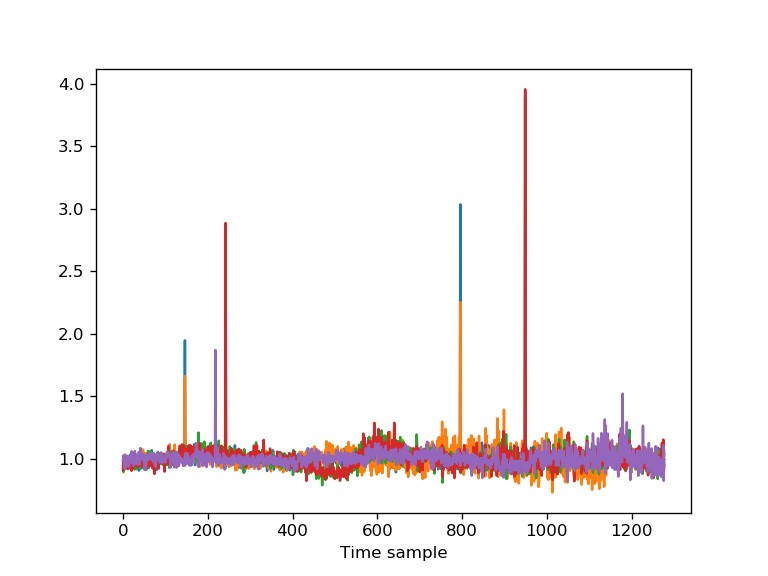

Text(0.5, 0, 'Time sample')

In [225]:
%matplotlib notebook
for i,f in enumerate(ch_freq[5:10]):
    x = range(len(dynspec[i]))
    #plt.plot(x, dynspec[i])
    popt, pcov = optimize.curve_fit(poly_fct, x, dynspec[i])
    plt.plot(x, dynspec[i]/poly_fct(x, *popt))
plt.xlabel("Time sample")
    

In [264]:
dynsfit = np.zeros(dynspec.shape)
for i,f in enumerate(ch_freq):
    x = range(len(dynspec[i]))
    z = np.polyfit(x, dynspec[i], 3)
    #popt, pcov = optimize.curve_fit(poly_fct, x, dynspec[i])
    dynsfit[i]=dynspec[i]/poly_fct(x, *popt)

<IPython.core.display.Javascript object>


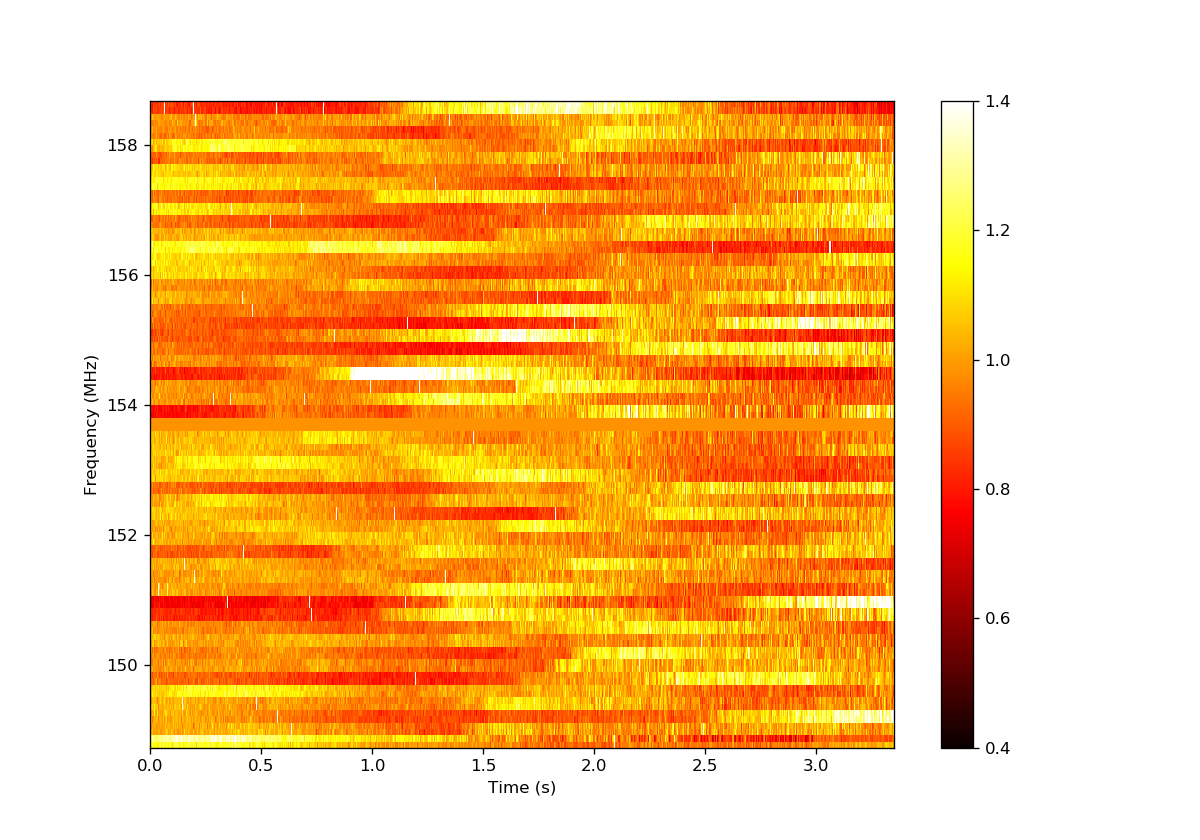

Text(0, 0.5, 'Frequency (MHz)')

In [220]:
%matplotlib notebook
cmin = min([np.median(dynsfit)-np.std(dynsfit), 0])
cmax = np.median(dynsfit)+np.std(dynsfit)

plt.figure(figsize=(10,7))
plt.imshow(dynsfit,aspect='auto',vmin=0.4, vmax=1.4,origin='lower',interpolation='nearest',cmap='hot',extent=[0,dynspec.shape[1]*tch*t_int,min(ch_freq),max(ch_freq)])
plt.colorbar()

plt.xlabel("Time (s)")
plt.ylabel("Frequency (MHz)")

Whole band

(102, 1278)
range(0, 1278)


<IPython.core.display.Javascript object>


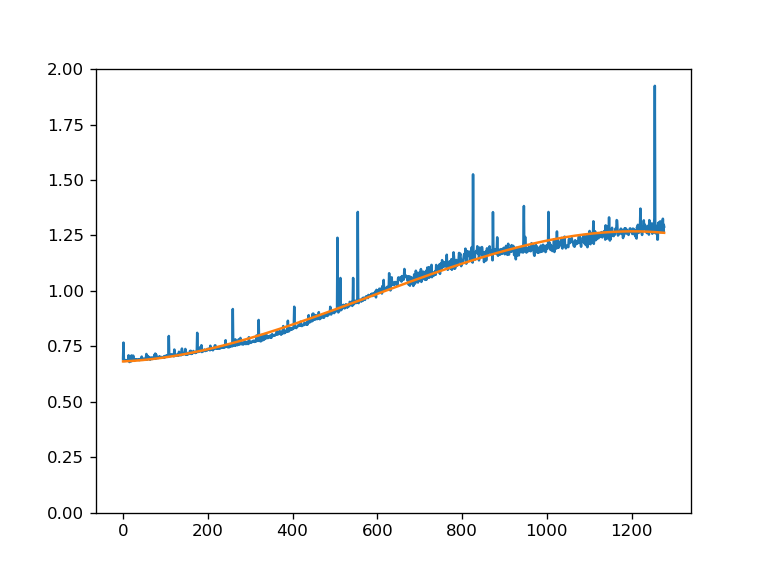

0.5864667069444551
1.2684974687973645 0.6820307618585212 0.9999999999904311


In [272]:
%matplotlib notebook
print(dynspec.shape)
x = range(dynspec.shape[1])
print(x)
plt.plot(np.average(dynspec, axis=0))
popt, pcov = optimize.curve_fit(poly_fct, x, np.average(dynspec, axis=0))
dyn_avg = poly_fct(x, *popt)
plt.plot(x, poly_fct(x, *popt))
plt.ylim(0, 2)

dynsfit = np.zeros(dynspec.shape)
for i,f in enumerate(ch_freq):
    dynsfit[i]=dynspec[i]/poly_fct(x, *popt)
print((np.max(dyn_avg)-np.min(dyn_avg))/np.average(dyn_avg))
print(np.max(dyn_avg),np.min(dyn_avg),np.average(dyn_avg))

<IPython.core.display.Javascript object>


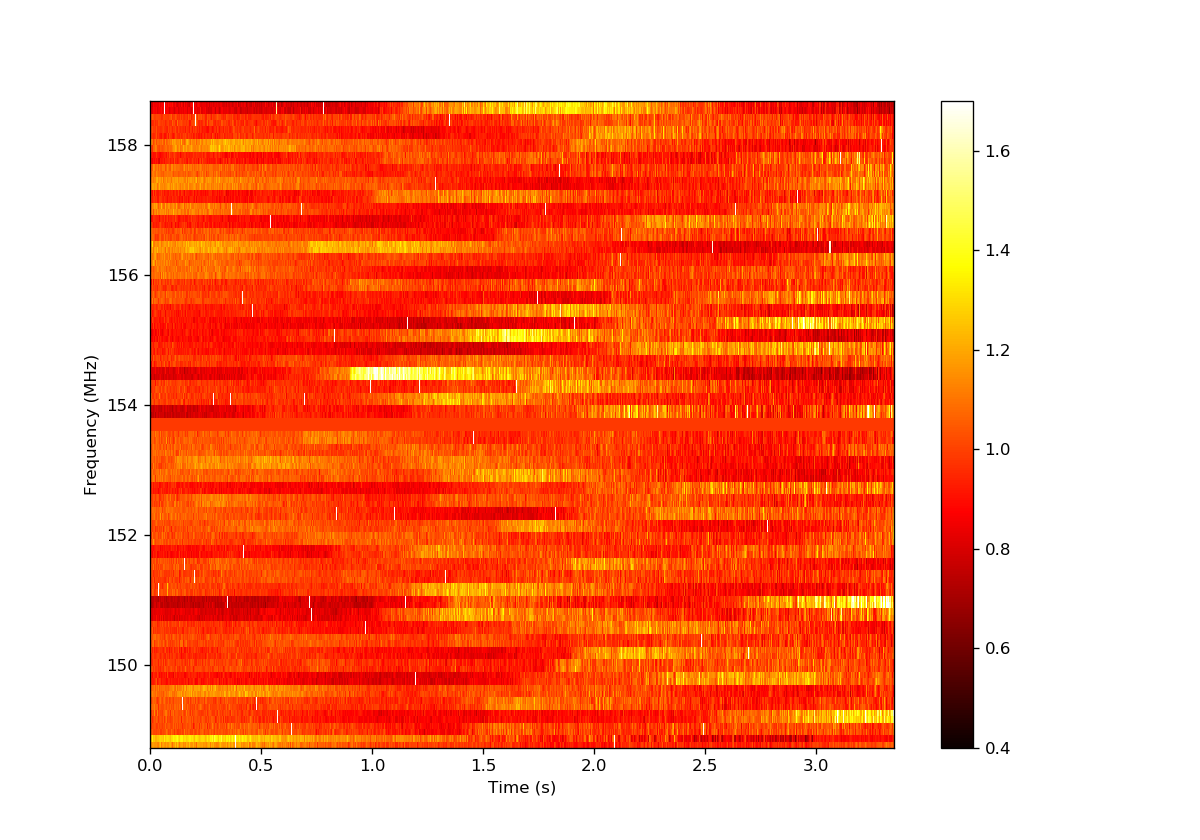

Text(0, 0.5, 'Frequency (MHz)')

In [221]:
%matplotlib notebook
cmin = min([np.median(dynsfit)-np.std(dynsfit), 0])
cmax = np.median(dynsfit)+np.std(dynsfit)

plt.figure(figsize=(10,7))
plt.imshow(dynsfit,aspect='auto',vmin=0.4, vmax=1.7,origin='lower',interpolation='nearest',cmap='hot',extent=[0,dynspec.shape[1]*tch*t_int,min(ch_freq),max(ch_freq)])
plt.colorbar()

plt.xlabel("Time (s)")
plt.ylabel("Frequency (MHz)")

In [143]:
print(dynspec.shape)

(102, 1278)


4.7641064916014155 4.9673703549841335
(array([50, 51]),)


<IPython.core.display.Javascript object>


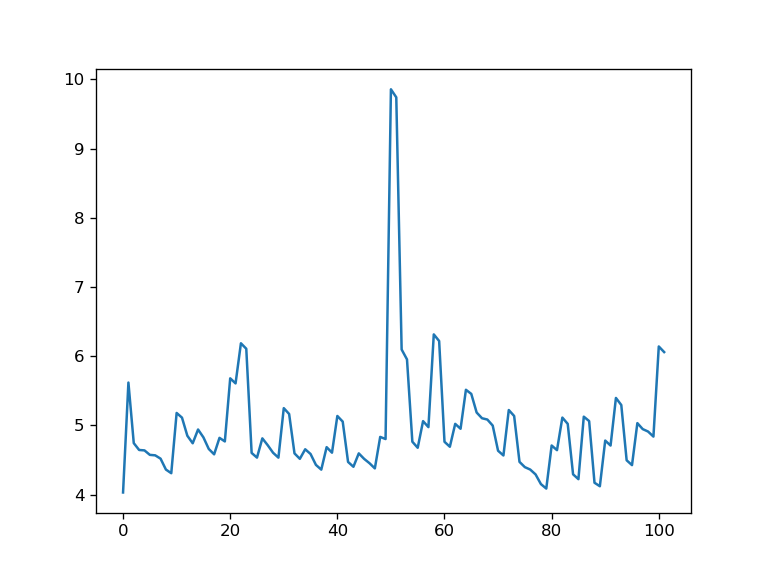

In [196]:
%matplotlib notebook
print(np.median(spectrum), np.average(spectrum))
print(np.where(spectrum>2*np.median(spectrum)))
plt.plot(spectrum)

In [46]:
dd_ds = dd.freq_to_delay(DM,np.array([200e6,fsb[-1]]),1)

In [145]:
t0[-1]-0.36999

46.63000744

## Dedispersing data

In [146]:
ch_freq = np.linspace(min(fch),max(fch),dynspec.shape[0])[:150]
test = np.delete(dynspec, 121,0)
ch_freq = np.delete(ch_freq, 121)
print(max(ch_freq), min(ch_freq))
offsets = dd.freq_to_delay(DM, ch_freq, tch*t_int)
print(min(offsets), max(offsets))

dd_dynspec = dd.dedisperse_array(dynspec[:149], DM, ch_freq, tch*t_int)

IndexError: index 121 is out of bounds for axis 0 with size 102

<IPython.core.display.Javascript object>


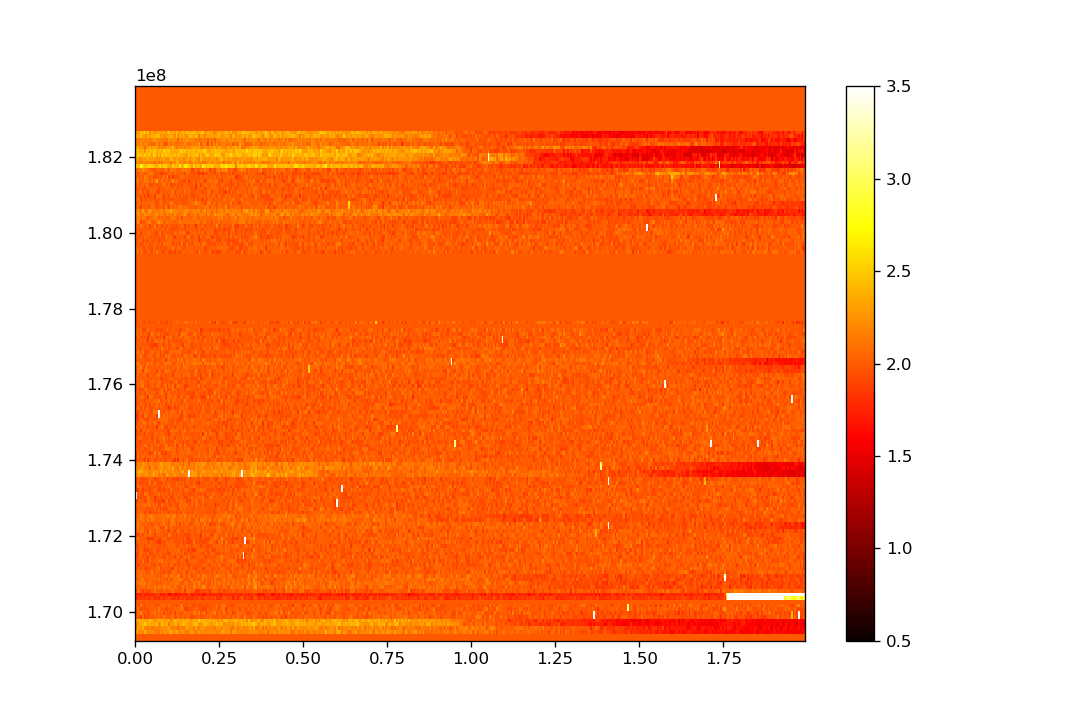

In [93]:
%matplotlib notebook
plt.figure(figsize=(9,6))
plt.imshow(test[:149],aspect='auto',vmin=0.5, vmax=3.5,origin='lower',interpolation='nearest',cmap='hot',extent=[0,dynspec.shape[1]*tch*t_int,min(ch_freq),max(ch_freq)])
plt.colorbar()
#plt.hlines(ch_freq[121],0,dynspec.shape[1]*tch*t_int)

In [169]:
%matplotlib notebook
ext = [0,dd_dynspec.shape[0]*tch*t_int,min(ch_freq),max(ch_freq)]
#plt.imshow(dd_dynspec,aspect='auto',origin='lower',interpolation='nearest',cmap='hot')
plt.plot(np.linspace(0, dd_dynspec.shape[0]*tch*t_int, len(dd_dynspec)), dd_dynspec)
plt.title("150 frequency channels")
plt.xlabel("Time (s)")
# plt.xlim(0, 0.15)
# plt.ylim(290,315)

NameError: name 'dd_dynspec' is not defined